# Setting

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [31]:
import torchvision
import cv2 as cv
import torch.nn as nn

In [3]:
import sys
import os
import pdb
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets

In [4]:
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
from unetmodelscript.model import Unet
from trainer import Trainer
from dataset import SteelDataset,provider

In [6]:
# sample_submission_path = '../input/severstal-steel-defect-detection/sample_submission.csv'
train_df_path = '../data/train.csv'
data_folder = "../data/"
test_data_folder = "../data/test_images/"
sample_submission_path = '../data/sample_submission.csv'
test_data_folder = "../data/test_images"

In [28]:
import colorlover as cl

colors = cl.scales['4']['qual']['Set3']
labels = np.array(range(1,5))

# combining into a dictionary
palette = dict(zip(labels, np.array(cl.to_numeric(colors))))

# Functions


In [81]:

def mask_to_contours(image, mask_layer, color):
    """ converts a mask to contours using OpenCV and draws it on the image
    """
#     pdb.set_trace()
    mask_layer = cv2.convertScaleAbs(mask_layer)
    # https://docs.opencv.org/4.1.0/d4/d73/tutorial_py_contours_begin.html
    contours, hierarchy = cv.findContours(mask_layer, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    image = cv.drawContours(image, contours, -1, color, 2)
        
    return image

def visualise_mask(imgs, masks):
    """ open an image and draws clear masks, so we don't lose sight of the 
        interesting features hiding underneath 
    """

    # going through the 4 layers in the last dimension 
    # of our mask with shape (256, 1600, 4)
    # we go through each image
    
    for index in range(imgs.shape[0]):

        img= imgs[index].numpy().transpose((1, 2, 0))
        mask = masks[index].numpy().transpose((1, 2, 0))
        
        fig, axes = plt.subplots(mask.shape[-1], 1, figsize=(16, 20))
        fig.tight_layout()
        
        for i in range(mask.shape[-1]):
            # indeces are [0, 1, 2, 3], corresponding classes are [1, 2, 3, 4]
            label = i + 1
            ax = axes[i,]
            # add the contours, layer per layer 
            image = mask_to_contours(img, mask[:,:,i], color=palette[label])
            
            ax.set_title("In image {} for defect {}".format(index,i))
            ax.axis('off')
            ax.imshow(image.get());

#     return image



In [21]:
def show_mask_image(imgs,masks=None):
    """
    Mask is 4 dimension because we have mask for 4 different classes
    """
    filenames = "img"
#     plt.figure(figsize=(14,50)) #20,18
#     pdb.set_trace()
#     if not predict:
#         if len(imgs.shape)==4 and len(masks.shape)==4:
    for index in range(imgs.shape[0]):  
        img= imgs[index].numpy().transpose((1, 2, 0))
#             img = img.astype('uint8') # this line make image pixel value to 0
        if type(masks) is np.ndarray:
            mask = masks.transpose((1, 2, 0))
        else:
            mask = masks[index].numpy().transpose((1, 2, 0))
        extra = 'Has defect type:'
        fig, ax = plt.subplots(figsize=(15, 50))
        for j in range(4):
            msk = mask[:,:,j]
            if np.sum(msk)!=0: extra += ' '+str(j+1)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,0] = 210 # green
            elif j==2: img[msk==1,0] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255

        plt.axis('off')
        plt.title(extra)
        plt.imshow(img)
        plt.show()


# Data exploration with dataloader. Making sure that data is correct from dataloader

In [82]:
dl_train = provider(data_folder,df_path=train_df_path,phase='train',batch_size=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


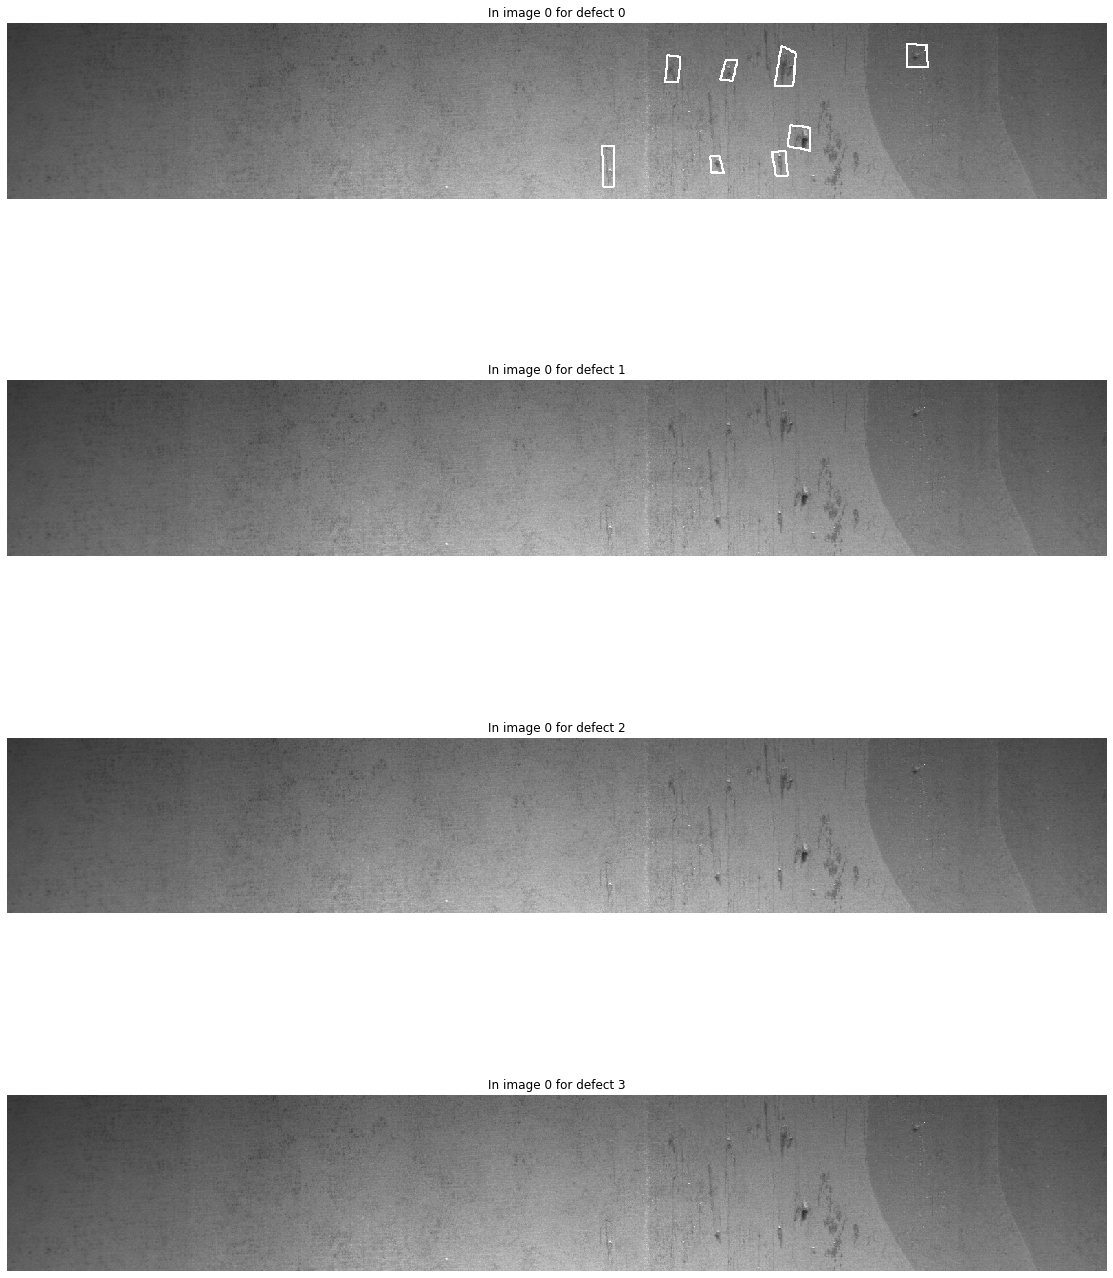

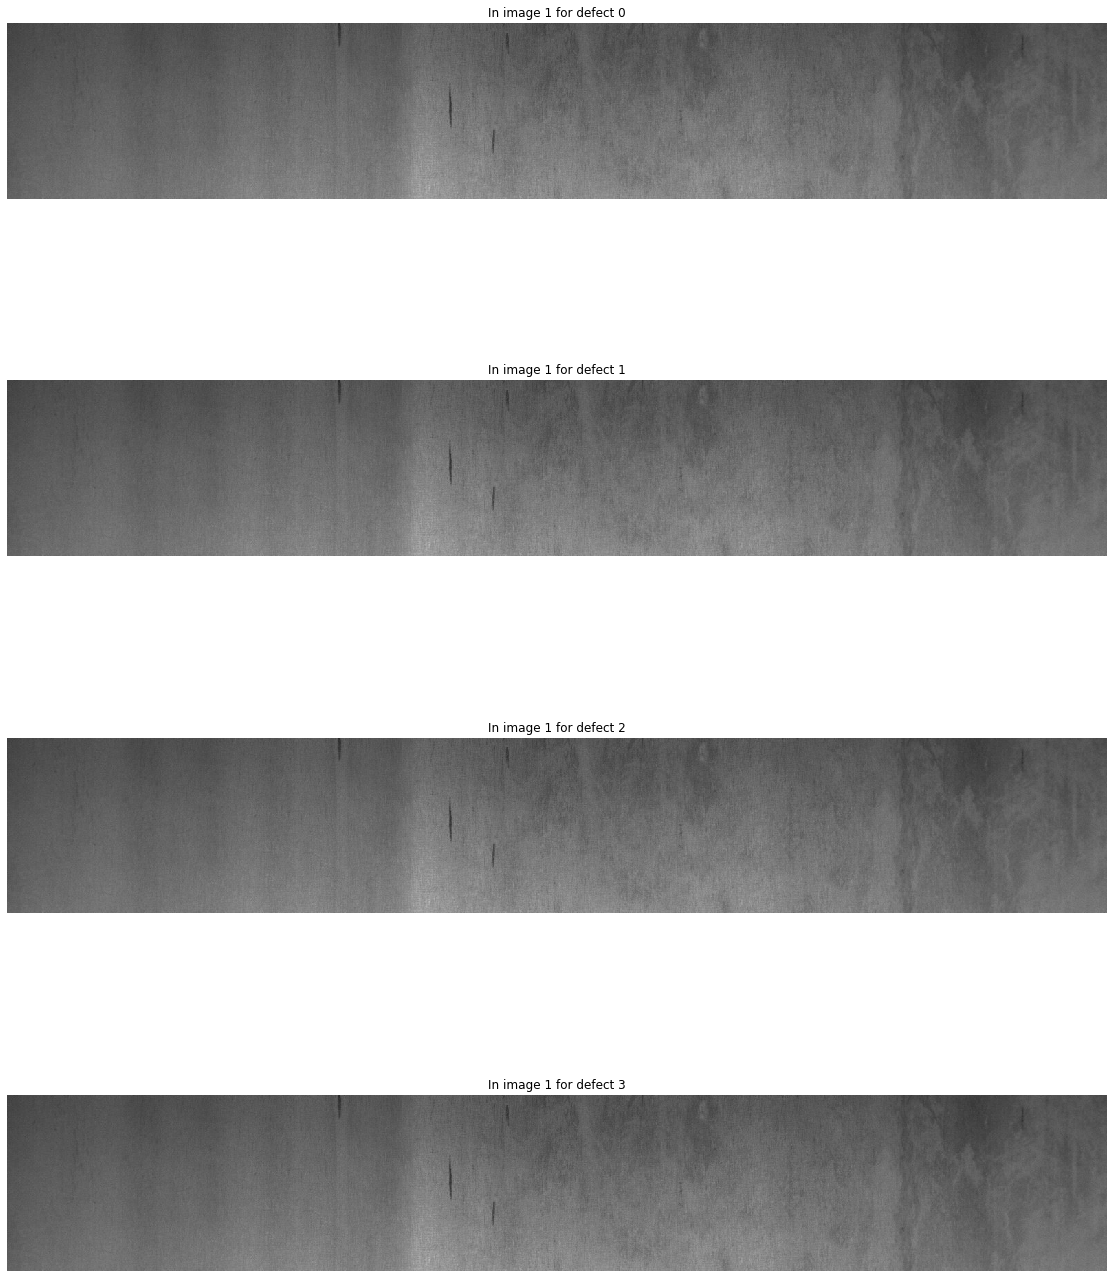

In [84]:
imgs,masks = next(iter(dl_train))
visualise_mask(imgs,masks)

In [30]:
# color code
# Yellow dam-1
# green 2
# blue 3
# magenta 4
data_button = widgets.Button(description='Next Images')
d_out = widgets.Output()

def d_on_button_clicked(_):
      # "linking function with output"
    with d_out:
        # what happens when we press the button
        clear_output()
        imgs,masks = next(iter(dl_train))
        show_mask_image(imgs,masks)
data_button.on_click(d_on_button_clicked)
widgets.VBox([data_button,d_out])


# Model and Training

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '2,3'

In [17]:
model = Unet("resnet18", encoder_weights="imagenet", classes=4, activation=None)

In [18]:
from trainer_multi import Trainer
model_trainer = Trainer(model,data_folder,train_df_path)

In [19]:
model_trainer.start()

Starting epoch: 0 | phase: train | ⏰: 21:51:55


/home/train_ami/Kaggle/Steel/train.py:45: RuntimeWarning: Mean of empty slice
  ious.append(np.nanmean(compute_ious(pred, label, classes)))
/home/train_ami/Kaggle/Steel/train.py:46: RuntimeWarning: Mean of empty slice
  iou = np.nanmean(ious)


Loss: 0.2977 | IoU: 0.0036 | dice: 0.0051 | dice_neg: 0.0030 | dice_pos: 0.0069
Starting epoch: 0 | phase: val | ⏰: 21:58:10
Loss: 0.1728 | IoU: 0.0008 | dice: 0.0814 | dice_neg: 0.1645 | dice_pos: 0.0015
******** New optimal found, saving state ********

Starting epoch: 1 | phase: train | ⏰: 21:59:21
Loss: 0.1083 | IoU: 0.1250 | dice: 0.1907 | dice_neg: 0.2145 | dice_pos: 0.1708
Starting epoch: 1 | phase: val | ⏰: 22:05:28
Loss: 0.0698 | IoU: 0.2364 | dice: 0.4254 | dice_neg: 0.5499 | dice_pos: 0.3100
******** New optimal found, saving state ********

Starting epoch: 2 | phase: train | ⏰: 22:06:37
Loss: 0.0534 | IoU: 0.2523 | dice: 0.3622 | dice_neg: 0.3927 | dice_pos: 0.3316
Starting epoch: 2 | phase: val | ⏰: 22:12:45
Loss: 0.0451 | IoU: 0.1634 | dice: 0.4679 | dice_neg: 0.7369 | dice_pos: 0.2173
******** New optimal found, saving state ********

Starting epoch: 3 | phase: train | ⏰: 22:13:54
Loss: 0.0343 | IoU: 0.2882 | dice: 0.5227 | dice_neg: 0.6868 | dice_pos: 0.3730
Starting ep

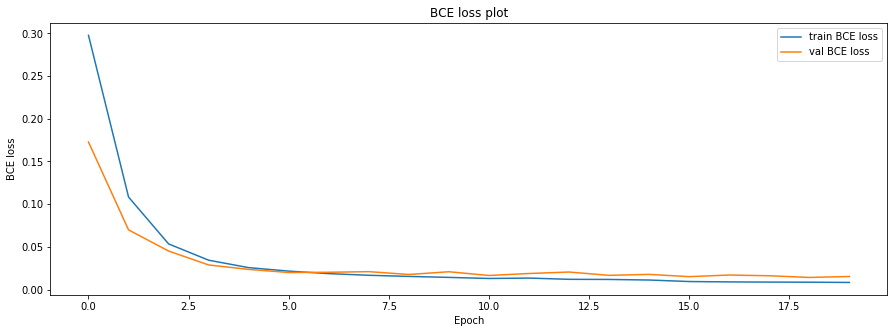

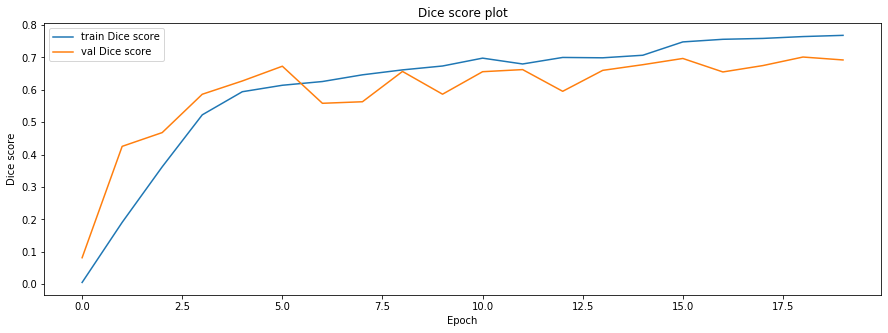

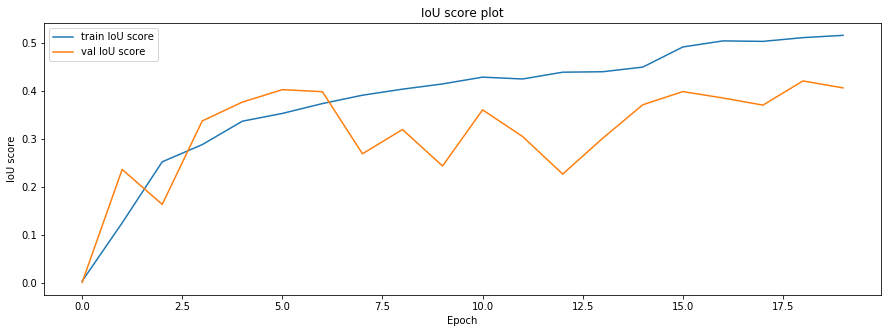

In [20]:
# PLOT TRAINING
losses = model_trainer.losses
dice_scores = model_trainer.dice_scores # overall dice
iou_scores = model_trainer.iou_scores

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

plot(losses, "BCE loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")

# Inference

In [8]:
# for inference we will use only GPU 2
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

In [9]:
import pdb
import os
import cv2
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset
from albumentations import (Normalize, Compose)
from albumentations.torch import ToTensor
import torch.utils.data as data

In [10]:
from utils import mask2rle
from processing import post_process
from dataset import TestDataset


In [11]:
# initialize test dataloader
best_threshold = 0.5
num_workers = 2
batch_size = 1
print('best_threshold', best_threshold)
min_size = 3500
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
df = pd.read_csv(sample_submission_path)
testset = DataLoader(
    TestDataset(test_data_folder, df, mean, std),
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
)

best_threshold 0.5


In [14]:
df.shape

(7204, 3)

In [16]:
# Initialize mode and load trained weights
ckpt_path = "./model_10_12.pth"
device = torch.device("cuda:0")
model = Unet("resnet18", encoder_weights=None, classes=4, activation=None)
# model.to(device)
model = nn.DataParallel(model)
model.eval()
state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])

<All keys matched successfully>

### Visualize the predicted images

In [20]:
button = widgets.Button(description='Next Epoch')
out = widgets.Output()

def on_button_clicked(_):
      # "linking function with output"
    with out:
        # what happens when we press the button
        clear_output()
        
        fnames, images = next(iter(testset))
        predictions = []
        batch_preds = torch.sigmoid(model(images.to(device)))
        batch_preds = batch_preds.detach().cpu().numpy()
        for fname, preds in zip(fnames, batch_preds):
            for cls, pred in enumerate(preds):
                pred, num = post_process(pred, best_threshold, min_size)
                predictions.append(pred)

            masks = np.vstack(predictions)
            #         print(masks.shape)
            masks = masks.reshape(4,256,1600)
            show_mask_image(images,masks)
            
            
button.on_click(on_button_clicked)
widgets.VBox([button,out])

##  Generate submission file

In [44]:
predictions = []
for i, batch in enumerate(tqdm(testset)):
    fnames, images = batch
    batch_preds = torch.sigmoid(model(images.to(device)))
    batch_preds = batch_preds.detach().cpu().numpy()
    for fname, preds in zip(fnames, batch_preds):
        for cls, pred in enumerate(preds):
            pred, num = post_process(pred, best_threshold, min_size)
            rle = mask2rle(pred)
            name = fname + f"_{cls+1}"
            predictions.append([name, rle])

# save predictions to submission.csv
df = pd.DataFrame(predictions, columns=['ImageId_ClassId', 'EncodedPixels'])
df.to_csv("submission.csv", index=False)

100%|██████████| 1801/1801 [02:04<00:00, 14.45it/s]
